### NBA Hall of Fame or Ball of Lame - Web Scraping and Cleaning
Name: Cobi Toeun <br>

Email: u1230512@utah.edu -- cobitoeun6901@gmail.com <br>

UID: u1230512 <br>

All data has been web scraped from [Basketball-Reference.com](https://www.basketball-reference.com/).
To prevent web page overload, I have downloaded every page I need to complete scraping, analysis and predictions. Each page can be found in the [*Webpages*](Webpages) folder.
<br>

**Webscraped data have been downloaded and extracted from these pages:**
- [Basketball-Reference Homepage](https://www.basketball-reference.com/)
- [NBA Player Directory](https://www.basketball-reference.com/players/)
- [Kobe Bryant Career Stats](https://www.basketball-reference.com/players/b/bryanko01.html) (we'll use Kobe's page as an example, but I've scraped from all NBA players)

### Import necessary libraries

In [17]:
# import necessary libraries
import requests
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen

import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import time
import os
import sys
import csv
import string
import math

import statsmodels.formula.api as sm
from statistics import mode

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option( "display.max_columns", 100)

# we'll want to get the alphabet to name folders and get the first and last initals of players
alphabet = list(string.ascii_lowercase)

Here I will create some functions to create folders in the directory to store html pages, images, and csv files.

In [84]:
# create new directories to store downloaded html pages, csv files, and graphs
for letter in alphabet:
    if not os.path.exists('Webpages/Players Directory/{}-players'.format(letter)):
        os.makedirs('Webpages/Players Directory/{}-players'.format(letter))

if not os.path.exists('csv_files'):
    os.makedirs('csv_files')
    
if not os.path.exists('graphs'):
    os.makedirs('graphs')

## Data Processing
I'll start to web scrape from this page since it has all current and former NBA players:
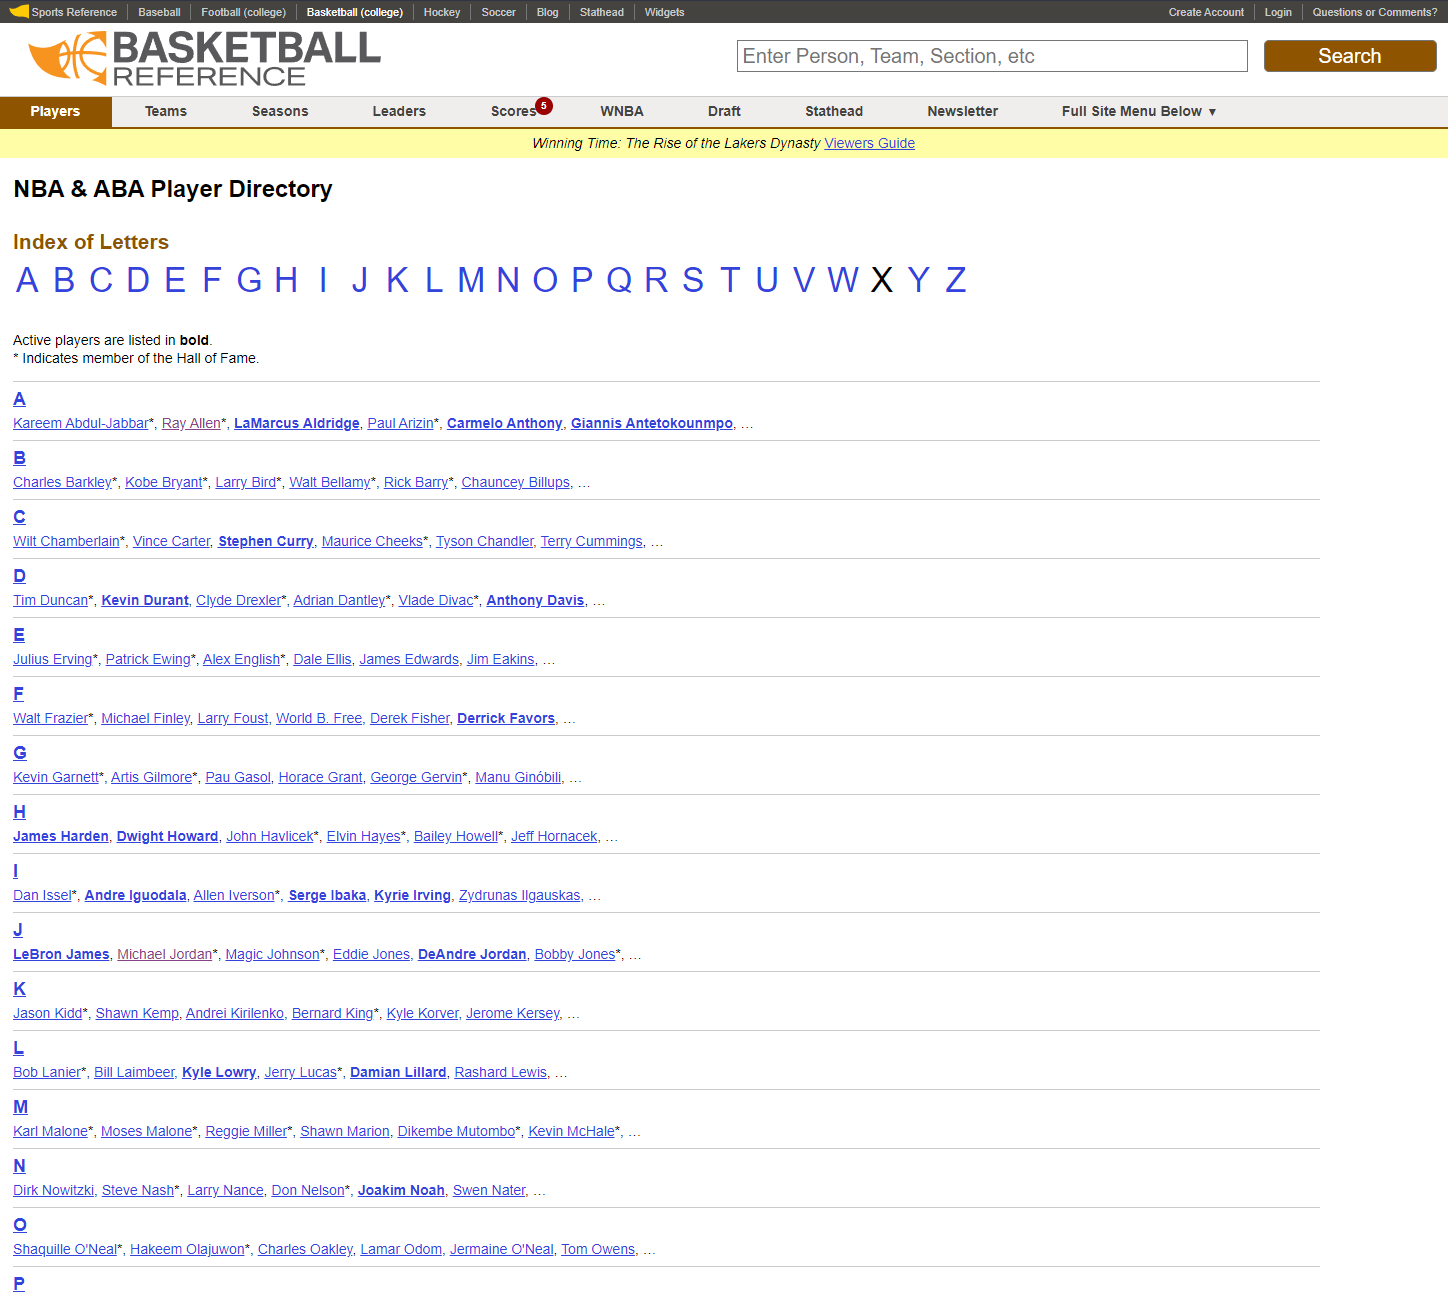

In the table, if a player is bolded, they are currently an active player and retired otherwise. The image below provides a visual representation (my function below touches on this more):
![active_players.png](images/active-players-bolded.png)
<br>

Unsurprisingly some players have the same first and last name. I handle this by ending all unqiue names with 01, meaning they are the 'first'. If a duplicate name is encountered, then I will increment a declared counter. For example, there are two **Dan Anderson**. The earliest player will be labeled *Dan Anderson01* and the other *Dan Anderson02*:
![players_with_same_name.png](images/players_with_same_name.png)
<br>

In [4]:
# download the basketball-reference homepage
urllib.request.urlretrieve('https://www.basketball-reference.com/','Webpages/homepage.html')

# download the current players of 2022 page
urllib.request.urlretrieve('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html',
                           'Webpages/2022-Players.html')

# download the directory pages corresponding to each players first letter of their last name
for letter in alphabet:
    urllib.request.urlretrieve('https://www.basketball-reference.com/players/{}/'.format(letter), 
                               'Webpages/Players Directory/{}-players-page.html'.format(letter))

In [ ]:
# inits of list -- some players have the same first and last name so we'll handle that with a set
players_list, players_names, players_urls, active, duplicate_names = [], [], [], {}, set()

In [5]:
# grab player names and links -- the table helps use determine if a player is currently active
for letter in alphabet:
    # I've already downloaded the necessary pages, so lets grab them locally
    players_soup = BeautifulSoup(open('Webpages/Players Directory/{}-players-page.html'.format(letter), encoding="utf8"), 'html.parser')
    li = players_soup.select('div#div_players table#players tbody th[data-stat=player]')
    for link in li:
        players_list.append(link.a.get('href'))
        try:
            # check if a player is active
            player_name = link.strong.get_text()
            players_names.append(player_name)
            # all players will end with 01
            # if we find players with the same name, we'll increase the count 
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # based on site data, bold players are active (even if injured)
            active['{}0{}'.format(player_name, count)] = 1
        except AttributeError:
            # throws exception if player is not active
            player_name = link.get_text().replace('*', '')
            players_names.append(player_name)
            # all players will end with 01
            # if we find players with the same name, we'll increase the count 
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # retired players/unactive players are not bolded
            active['{}0{}'.format(player_name, count)] = 0

duplicate_names.clear()            

# create reference links for each player
for player in players_list:
    players_urls.append('https://www.basketball-reference.com{}'.format(player))

In [6]:
# make sure lists match in length
print(len(players_list))
print(len(players_names))
print(len(players_urls))

5020
5020
5020


In [7]:
# some international players have characters python can't read, so we'll translate
translate_eng = {'Č':'c', 'Ć': 'c', 'İ':'i', 'Š':'s', 'Ş':'s', 'Ž':'z'}
suffix = ['Jr.', 'Sr.', 'I', 'II', 'III', 'IV', 'V']

# get last initial of players name so we can store into folders
def get_last_initial(player_name):
    # there is an exception thrown for one player, so we'll handle with try/except block
    try:
        # handle middle names
        if len(player_name) == 3 and player_name[2] not in suffix:
            return player_name[2][0].lower()
        # handle last names that aren't in english alphabet
        elif player_name[1][0] in translate_eng: 
            return translate_eng.get(player_name[1][0])
        else: return player_name[1][0].lower()
    # Nenê's 'last name' isn't included in web scrape
    except IndexError: 
        if player_name[0] == 'Nenê': return 'h'

Here we'll actually download and store all player pages. Since I have them downloaded locally, it won't overload the official webpage. I will use the custom function above to extract a players last initial. I'll use their last initial to group them within a folder. For example, *Lebron James* will be placed in j-players. The function will ignore suffixes for player such as Tim Hardaway Jr; hence *Tim Hardaway Jr.* = *Tim Hardaway*.

In [ ]:
# download all the players pages
i = 0

for player_link in players_urls:
    player_name = players_names[i].split(); print(player_name)
    last_initial = get_last_initial(player_name)
    
    # handle players with same names
    if players_names[i] in duplicate_names: count+=1
    else: count=1; duplicate_names.add(players_names[i])
        
    urllib.request.urlretrieve(player_link, 
                'Webpages/Players Directory/{}-players/{}0{}.html'.format(last_initial, players_names[i], count))
    i+=1
    
duplicate_names.clear()

Once all pages have been successfully stored locally, I can go ahead with the scraping and cleaning process! I have create multiple custom functions to extract specific data.

**This is the data to search and extract:**
- Debut (Year), Last Active (Year), YOE, Active or Retired, Total Games
- Career points, rebounds, assists, blocks, and steals (totals, per game and percentage)
- Averages (FG%, eFG%, FG3%, FT%, PER, WS)
- Awards and Accomplishments (All-Stars, MVPs, Championships, DPOYs, All-NBA, etc.)
- Year Inducted, Inducted as Player or Coach or Contributor (For current HoFs)

**Here is an example of Kobe Bryants's career stats and accomplishments:**
![kobe](images/kobe.png)
<br>

Using my browers built-in inspect function, I can view each HTML element then extract Kobe's awards and stats using BeautifulSoup and my custom functions: <br>
![kobe_awards.png](images/kobe_awards.png)
![kobe_stats.png](images/kobe_stats.png)

To extract the stats and awards of all players (using the browser's inspect element), I have implemented multiple custom functions below. Although all functions aren't optimal, they get the job done. Overall, the final output will be one large dataframe with all players and multiple descriptive columns.

In [73]:
# inits
stats_df_rows = []
awards_dict = {'hof':0, 'all_stars':0, 'score_champs':0, 'rbs_champs':0, 'ast_champs':0, 'stl_champs':0, 'blk_champs':0, 
               'nba_champs':0, 'all_nbas':0, 'most_improved':0, 'sixth_man':0, 'all_rookie':0, 'roy':0, 'all_defs':0, 'as_mvps':0, 
               'dpoys':0, 'mvps':0, 'finals_mvps':0, 'anniv_team':0}
convert_old_teams = {'TOT':'NA', 'NJN':'BRK', 'CHA':'CHO', 'NOK':'NOP', 'CHH':'CHO','INA':'IND',
                    'NOH':'NOP', 'PHX':'PHO', 'SEA':'OKC', 'VAN':'MEM', 'WSB':'WAS', 'PHW':'GSW',
                    'SFW':'GSW', 'MNL':'LAL', 'CIN':'SAC', 'KCO':'SAC', 'DNR':'DEN', 'FTW':'DET', 
                     'SDR':'HOU', 'SYR':'PHI', 'STL':'ATL', 'BAL':'WAS', 'BUF':'LAC','NOJ':'UTA','ROC':'SAC'}
avg_stats_dict = {'G':0,'PTS':0.0,'TRB':0.0,'AST':0.0,'STL':0.0,'BLK':0.0,'FG%':0.0,'FG3%':0.0,
              'FT%':0.0,'eFG%':0.0,'PER':0.0,'WS':0.0}
tot_stats_dict = {'PG':0,'PTS':0,'TRB':0,'AST':0,'STL':0,'BLK':0}
inducted_as = {'Player':0, 'Coach':0, 'Contributor':0, 'FB':0}

# it's hard to determine past first ballot hofs since it has constantly changed, so here's a list of current fb hofs
first_ballot_hofs = pd.read_csv('csv_files/first_ballot_hofs.csv')

# extract the number or value if award is present within player
def choose_award(awards_list, player):
    for award in awards_list:
        if 'Hall of Fame' in award: awards_dict['hof'] = 1
        elif 'x All Star' in award: awards_dict['all_stars'] = int(''.join(i for i in award if i.isdigit()))
        elif 'Scoring Champ' in award:
            awards_dict['score_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'TRB Champ' in award:
            awards_dict['rbs_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'AST Champ' in award:
            awards_dict['ast_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'STL Champ' in award:
            awards_dict['stl_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'BLK Champ' in award:
            awards_dict['blk_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA Champ' in award:
            awards_dict['nba_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-NBA' in award or 'All-BAA/NBA' in award:
            awards_dict['all_nbas'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-Rookie' in award: awards_dict['all_rookie'] = 1
        elif 'ROY' in award: awards_dict['roy'] = 1
        elif 'All-Defensive' in award:
            awards_dict['all_defs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Most Improved' in award:
            awards_dict['most_improved'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Sixth Man' in award:
            awards_dict['sixth_man'] = int(''.join(i for i in award if i.isdigit())) if 'x Sixth Man' in award else 1
        elif 'AS MVP' in award:
            awards_dict['as_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Def. POY' in award:
            awards_dict['dpoys'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'MVP' in award:
            if 'Finals' in award: awards_dict['finals_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
            else: awards_dict['mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA 75th Anniv. Team' in award: awards_dict['anniv_team'] = 1
        else: continue # skip all-aba, aba champ, bba, etc (irrelevant to current players)

# get all the list of achivements and awards for player
def get_achivements(link):
    li = link.select("ul[id=bling] > li > a")
    for link in li:
        awards.append(link.get_text())

def get_info(link):
    info = link.find(id='info')
    for line in info.find_all('p'):
        try:
            # use regex to extract hof induction year
            line = re.search('Hall of Fame: Inducted as (\w+) in (\d{4})', line.get_text())
            inducted_as[line.group(1)] = 1
            hof_year = line.group(2); break
        except AttributeError: hof_year = 0; continue
    return int(hof_year) 

def extract_table(link, years, position, teams):
    table = link.find('table')
    if table:
        table_body = table.find('tbody')
        # loop over list of players
        for row in table_body.findAll('tr'):
            try:
                # get some player's pos and team for each year
                year = row.find('a').get_text();
                pos = row.find('td', {'data-stat':'pos'}).get_text();
                team = row.find('td', {'data-stat':'team_id'}).get_text();
                lg = row.find('td', {'data-stat':'lg_id'}).get_text();
                # add year
                if (len(year) <= 7): years.add(int(year[:4]))
                # add positions
                if pos != '': position.append(pos)
                # add main team
                get_team = convert_old_teams.get(team) if team in convert_old_teams else team
                if get_team == 'NA': 
                    find_teams = row.find('tr', {'class':'light_text partial_table'})
                    multi_team = find_teams.find('td', {'data-stat':'team_id'}).get_text();
                    for team in multi_team: 
                        get_team = convert_old_teams.get(team) if team in convert_old_teams else team
                        teams.append(get_team)
                else:
                    teams.append(get_team)
                if lg != '': league.append(lg)
            except (AttributeError, IndexError):
                continue
    # not the best way to extract the table information but it works -- will optimize later
    total_table = link.find('table', {'id':'totals'}).find('tfoot'); row = total_table.find('tr')
    # we'll also extract some total stats
    try: pts = row.find('td', {'class':'right','data-stat':'pts'}).get_text(); tot_stats_dict['PTS'] = pts
    except AttributeError: pass
    try: trb = row.find('td', {'class':'right','data-stat':'trb'}).get_text(); tot_stats_dict['TRB'] = trb
    except AttributeError: pass
    try: ast = row.find('td', {'class':'right','data-stat':'ast'}).get_text(); tot_stats_dict['AST'] = ast
    except AttributeError: pass
    try: spg = row.find('td', {'class':'right','data-stat':'stl'}).get_text(); tot_stats_dict['STL'] = spg
    except AttributeError: pass
    try: bpg = row.find('td', {'class':'right','data-stat':'blk'}).get_text(); tot_stats_dict['BLK'] = bpg
    except AttributeError: pass
    
    # we'll want to extract average steals and blocks
    avg_table = link.find('table', {'id':'per_game'}).find('tfoot');
    row = avg_table.find('tr');
    # gather average steals and blocks
    try: avg_stl = row.find('td', {'class':'right','data-stat':'stl_per_g'}).get_text(); avg_stats_dict['STL'] = avg_stl
    except AttributeError: pass
    try: avg_blk = row.find('td', {'class':'right','data-stat':'blk_per_g'}).get_text(); avg_stats_dict['BLK'] = avg_blk
    except AttributeError: pass
        
# get all major stats of player
def get_stats(stats):
    for stat in stats.find_all('div'):
        try:
            get_stat = stat.select('p')[1].get_text()
            set_stat = get_stat if (get_stat != 'Career' and get_stat != '-') else 0.0
            avg_stats_dict[stat.find('span').strong.get_text()] = float(set_stat)
        # handle out of index error for some players
        except IndexError: return 0
            
# extract each available stat for current player
def extract_player_info(player_link, player_name, awards, years, get_player_map, position, teams, league):
    with open(player_link, 'rb') as html:
        player_link_soup = BeautifulSoup(html)
    
    # extract player awards and accomplishments and place into list
    get_achivements(player_link_soup)
    averages = player_link_soup.find('div', {'class': 'stats_pullout'})
    extract_table(player_link_soup, years, position, teams)
    # sort set and convert to list so we can access first and last years
    years_list = sorted(list(years))
    
    # extract stats and set awards
    name = player_name
    main_pos = mode(position) if len(position) != 0 else 'NA'
    '''
    the team a player is mainly associated with -- this technically isn't correct,
    but we'll infer a player's main team is the team they played the most seasons with
    '''
    asso_team = mode(teams) if len(teams) != 0 else 'NA'
    main_lg = mode(league) if len(league) != 0 else 'NA'
    yoe = len(years)
    debut = years_list[0] if len(years_list) > 0 else 0
    last_active = (years_list[-1] + 1) if yoe >= 1 else 0
    # based on site data, bold players are active (even injured players)
    retired = 1 if active.get(get_player_map) == 0 else 0
    
    # extract main stats
    get_stats(averages)
    
    # check if players have alteast one award
    if len(awards) != 0: choose_award(awards, player_name)
    year_inducted = get_info(player_link_soup) if awards_dict.get('hof') == 1 else 0
    # check if player is first ballot hall of famer
    first_ballot = 1 if (name in list(first_ballot_hofs.First_Ballot) and awards_dict.get('hof') == 1) or (year_inducted - last_active) == 4 else 0
    
    player_stats = {'Player':name, 'Debut':debut, 'Last Active':last_active, 'YOE':yoe, 'Retired':retired, 'Position':main_pos, 
                        'Team':asso_team,'League':main_lg,'Total Games':avg_stats_dict.get('G', 0), 'Career PPG':avg_stats_dict.get('PTS', 0.0), 
                        'Total PTS':tot_stats_dict.get('PTS', 0),'Career RPG':avg_stats_dict.get('TRB', 0.0),'Total RBS':tot_stats_dict.get('TRB', 0),'Career APG':avg_stats_dict.get('AST', 0.0), 
                        'Total AST':tot_stats_dict.get('AST', 0),'Career SPG':avg_stats_dict.get('STL', 0.0),'Total STL':tot_stats_dict.get('STL', 0),'Career BPG':avg_stats_dict.get('BLK', 0.0),
                         'Total BLK':tot_stats_dict.get('BLK', 0),'Career FG%':avg_stats_dict.get('FG%', 0.0), 
                    'Career FG3%':avg_stats_dict.get('FG3%', 0.0), 'Career FT%':avg_stats_dict.get('FT%', 0.0), 'Career eFG%':avg_stats_dict.get('eFG%', 0.0), 
                          'PER':avg_stats_dict.get('PER', 0.0),'Avg WS':round((avg_stats_dict.get('WS', 0.0)/float(yoe)), 1),'Total WS':avg_stats_dict.get('WS', 0.0),
                          'Hall of Fame':awards_dict.get('hof', 0),'First Ballot':first_ballot,'Inducted as Player':inducted_as.get('Player',0), 
                    'Inducted as Coach':inducted_as.get('Coach',0), 'Inducted as Contributor':inducted_as.get('Contributor',0),'Year Inducted':year_inducted, 
                          'All-Stars':awards_dict.get('all_stars', 0), 'Scoring Champs':awards_dict.get('score_champs', 0), 
                          'Rebound Champs':awards_dict.get('rbs_champs', 0),
                       'Assist Champs':awards_dict.get('ast_champs', 0), 'Steal Champs':awards_dict.get('stl_champs', 0), 
                          'Block Champs':awards_dict.get('blk_champs', 0), 
                        'NBA Champs':awards_dict.get('nba_champs', 0), 'All-NBA':awards_dict.get('all_nbas', 0), 
                          'All-Rookie':awards_dict.get('all_rookie', 0), 'ROY':awards_dict.get('roy', 0), 
                        'All-Defensive':awards_dict.get('all_defs', 0), 'Most Improved':awards_dict.get('most_improved', 0), 
                          'Sixth Man':awards_dict.get('sixth_man', 0), 'AS MVPs':awards_dict.get('as_mvps', 0), 
                        'DPOYs':awards_dict.get('dpoys', 0), 'MVPs': awards_dict.get('mvps', 0),'Finals MVPs':awards_dict.get('finals_mvps', 0), 
                        'NBA 75th Anniv. Team':awards_dict.get('anniv_team', 0)}
    # add stats awards to list
    stats_df_rows.append(player_stats); print(player_stats)

The code below is what does all the magic. It takes a while to run, so I have exported multiple different csv files that can be read into variables. All data have been exported below, but you can also check out [hof-analysis-predictions.ipynb](hof-analysis-predictions.ipynb) to view all loaded csv files.

In [ ]:
# go through each player
for player in players_names:
    # years may have duplicates
    awards, years, position, teams, league = [], set(), [], [], []
    global awards_dict; awards_dict = awards_dict.fromkeys(awards_dict, 0); print(player)
    global avg_stats_dict; avg_stats_dict = avg_stats_dict.fromkeys(avg_stats_dict, 0);
    global tot_stats_dict; tot_stats_dict = tot_stats_dict.fromkeys(tot_stats_dict, 0);
    global inducted_as; inducted_as = inducted_as.fromkeys(inducted_as, 0);
    player_name = player.split()
    last_initial = get_last_initial(player_name)
    
    # check for duplicate names
    if player in duplicate_names: count+=1
    else: count=1; duplicate_names.add(player)
    
    # get player identify number
    get_player_map = '{}0{}'.format(player, count)
    extract_player_info('Webpages/Players Directory/{}-players/{}.html'.format(last_initial, get_player_map), 
                        player, awards, years, get_player_map, position, teams, league)

duplicate_names.clear()

In [76]:
duplicate_names.clear()

## Data Cleaning

Now I'll move on to the data cleaning. My custom function above has already completed most of the cleaning, but we'll need to remove some players and refomat the types of some columns.

In [77]:
# create a dataframe of players
all_players_df = pd.DataFrame(stats_df_rows)

In [78]:
display(all_players_df)

,Player,Debut,Last Active,YOE,Retired,Position,Team,League,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
0,Alaa Abdelnaby,1990,1995,5,1,PF,POR,NBA,256.0,5.7,1465,3.3,846,0.3,85,0.3,71,0.3,69,50.2,0.0,70.1,50.2,13.0,1.0,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zaid Abdul-Aziz,1968,1978,10,1,C,HOU,NBA,505.0,9.0,4557,8.0,4065,1.2,601,0.6,131,1.0,205,42.8,0.0,72.8,0.0,15.1,1.8,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kareem Abdul-Jabbar,1969,1989,20,1,C,LAL,NBA,1560.0,24.6,38387,11.2,17440,3.6,5660,0.9,1160,2.6,3189,55.9,5.6,72.1,55.9,24.6,13.7,273.4,1,1,1,0,0,1995,19,2,1,0,0,4,6,15,1,1,11,0,0,0,0,6,2,1
3,Mahmoud Abdul-Rauf,1990,2001,9,1,PG,DEN,NBA,586.0,14.6,8553,1.9,1087,3.5,2079,0.8,487,0.1,46,44.2,35.4,90.5,47.2,15.4,2.8,25.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,Tariq Abdul-Wahad,1997,2003,6,1,SG,DEN,NBA,236.0,7.8,1830,3.3,776,1.1,266,0.8,184,0.4,83,41.7,23.7,70.3,42.2,11.4,0.6,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,Ante Žižić,2017,2020,3,0,C,CLE,NBA,113.0,6.0,674,3.9,446,0.6,64,0.2,22,0.4,40,58.1,0.0,71.1,58.1,17.4,1.2,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5016,Jim Zoet,1982,1983,1,1,C,DET,NBA,7.0,0.3,2,1.1,8,0.1,1,0.1,1,0.4,3,20.0,0.0,0.0,20.0,-0.8,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5017,Bill Zopf,1970,1971,1,1,PG,MIL,NBA,53.0,2.2,118,0.9,46,1.4,73,0,0,0,0,36.3,0.0,55.6,0.0,9.6,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5018,Ivica Zubac,2016,2022,6,0,C,LAC,NBA,359.0,8.3,2989,6.5,2339,1.1,408,0.3,112,0.8,302,59.7,10.0,75.4,59.7,19.2,4.3,25.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
print(all_players_df.shape) # everything looks good!

(5020, 50)


In [80]:
all_players_df.to_csv('csv_files/all_players.csv', index=False)

Since I am trying to predict current NBA players HoF's chances, I don't want to include ABA and BAA players as they are irrelevant in this analysis.

In [81]:
# we want to delete this players since they didn't play in the NBA for the majority of their careers
display(all_players_df[all_players_df['League'] == 'ABA'])
display(all_players_df[all_players_df['League'] == 'BAA'])

,Player,Debut,Last Active,YOE,Retired,Position,Team,League,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
18,George Adams,1972,1975,3,1,SF,SDA,ABA,215.0,7.7,1652,4.1,873,1.5,317,0.6,88,0.4,59,49.7,23.5,79.4,49.9,14.0,2.2,6.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,Matthew Aitch,1967,1968,1,1,PF,IND,ABA,45.0,5.6,252,3.6,160,0.4,18,0,0,0,0,40.5,0.0,67.5,40.5,11.9,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58,Bill Allen,1967,1968,1,1,C,ANA,ABA,38.0,7.9,300,7.1,269,0.6,23,0,0,0,0,42.9,100.0,58.6,43.2,11.9,0.6,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70,Willie Allen,1971,1972,1,1,PF,FLO,ABA,7.0,1.9,13,2.0,14,0.6,4,0,0,,,30.8,0.0,83.3,30.8,5.7,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87,Andrew Anderson,1967,1970,3,1,SG,OAK,ABA,194.0,10.7,2081,2.7,527,1.7,327,0,0,0,0,41.0,15.9,75.5,41.3,10.9,1.2,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,Howie Wright,1970,1972,2,1,SG,KEN,ABA,53.0,4.5,237,1.5,80,1.2,63,0,0,,,38.4,21.4,80.0,40.2,6.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4966,Joby Wright,1972,1976,3,1,PF,OKC,ABA,103.0,4.2,436,2.8,291,0.4,38,0.2,5,0.2,5,46.7,0.0,46.5,46.7,8.8,0.2,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4969,Leroy Wright,1967,1969,2,1,PF,PTP,ABA,27.0,2.4,65,5.1,138,0.6,15,0,0,0,0,38.4,0.0,33.3,38.4,5.7,0.1,0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4970,Lonnie Wright,1967,1972,5,1,SG,DEN,ABA,335.0,10.7,3590,2.7,913,1.9,641,0,0,,,40.7,25.5,72.1,42.3,10.1,1.2,5.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Player,Debut,Last Active,YOE,Retired,Position,Team,League,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
8,John Abramovic,1946,1948,2,1,NA,PIT,BAA,56.0,9.5,533,0.0,,0.7,37,0,0,0,0,23.7,0.0,68.6,0.0,0.0,-0.9,-1.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157,Chet Aubuchon,1946,1947,1,1,NA,DTF,BAA,30.0,2.2,65,0.0,,0.7,20,0,0,0,0,25.3,0.0,54.3,0.0,0.0,1.2,1.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
178,Johnny Bach,1948,1949,1,1,NA,BOS,BAA,34.0,3.5,119,0.0,,0.7,25,0,0,0,0,28.6,0.0,68.0,0.0,0.0,0.8,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
194,Norm Baker,1946,1947,1,1,NA,CHS,BAA,4.0,0.0,0,0.0,,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
203,Herschel Baltimore,1946,1947,1,1,NA,STB,BAA,58.0,2.4,138,0.0,,0.3,16,0,0,0,0,20.2,0.0,46.4,0.0,0.0,0.3,0.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4725,Ray Wertis,1946,1948,2,1,NA,TRH,BAA,68.0,3.6,246,0.0,,0.7,45,0,0,0,0,21.0,0.0,59.0,0.0,0.0,-0.7,-1.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4785,D.C. Wilcutt,1948,1950,2,1,NA,STB,BAA,59.0,2.2,128,0.0,,1.4,80,0,0,0,0,33.9,0.0,73.3,0.0,0.0,0.6,1.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4879,Ward Williams,1948,1949,1,1,NA,DET,BAA,53.0,4.1,215,0.0,,1.5,82,0,0,0,0,23.7,0.0,75.0,0.0,0.0,1.8,1.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5005,Harry Zeller,1946,1947,1,1,NA,PIT,BAA,48.0,7.5,362,0.0,,0.6,31,0,0,0,0,31.4,0.0,68.9,0.0,0.0,3.7,3.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
# create new dataframe to clean

# error checking -- we'll remove non-NBA players
all_nba_players_df_clean = all_players_df[(all_players_df['League'] != 'ABA') &
                                                    (all_players_df['League'] != 'BAA')]
all_nba_players_df_clean = all_nba_players_df_clean.fillna(0)
all_nba_players_df_clean.drop('League', axis=1, inplace=True)

# reformat and begin to clean the dataframe
float_cols = ['Career PPG','Career RPG','Career APG','Career SPG','Career BPG','Career FG%','Career FG3%',
                                          'Career FT%','Career eFG%','PER','Total WS']
int_cols = ['Total Games','Total PTS','Total RBS', 'Total AST','Total STL','Total BLK']

# if player has - as stat, replace with 0.0
all_nba_players_df_clean[float_cols] = all_nba_players_df_clean[float_cols].replace(('-',''), 0.0, regex=True).astype(np.float64)
all_nba_players_df_clean[int_cols] = all_nba_players_df_clean[int_cols].replace(('-',''), 0, regex=True).astype(np.int64)

# check if there are duplicate players and stats
display(all_nba_players_df_clean[all_nba_players_df_clean.duplicated()])

print(all_nba_players_df_clean.shape)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team


(4397, 49)


In [83]:
all_nba_players_df_clean.to_csv('csv_files/all_nba_players.csv', index=False)

### Retired players (HoF and Non-HoF)

In [23]:
# we'll want to grab all retired players to complete our predictive models
retired_players_df = all_nba_players_df_clean[all_nba_players_df_clean['Retired'] == 1]

display(retired_players_df)
print(retired_players_df.shape)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
0,Alaa Abdelnaby,1990,1995,5,1,PF,POR,256,5.7,1465,3.3,846,0.3,85,0.3,71,0.3,69,50.2,0.0,70.1,50.2,13.0,1.0,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zaid Abdul-Aziz,1968,1978,10,1,C,HOU,505,9.0,4557,8.0,4065,1.2,601,0.6,131,1.0,205,42.8,0.0,72.8,0.0,15.1,1.8,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kareem Abdul-Jabbar,1969,1989,20,1,C,LAL,1560,24.6,38387,11.2,17440,3.6,5660,0.9,1160,2.6,3189,55.9,5.6,72.1,55.9,24.6,13.7,273.4,1,1,1,0,0,1995,19,2,1,0,0,4,6,15,1,1,11,0,0,0,0,6,2,1
3,Mahmoud Abdul-Rauf,1990,2001,9,1,PG,DEN,586,14.6,8553,1.9,1087,3.5,2079,0.8,487,0.1,46,44.2,35.4,90.5,47.2,15.4,2.8,25.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,Tariq Abdul-Wahad,1997,2003,6,1,SG,DEN,236,7.8,1830,3.3,776,1.1,266,0.8,184,0.4,83,41.7,23.7,70.3,42.2,11.4,0.6,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4390,Derrick Zimmerman,2005,2006,1,1,PG,BRK,2,2.0,4,2.0,4,3.5,7,0.0,0,0.0,0,66.7,0.0,0.0,66.7,5.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4391,Stephen Zimmerman,2016,2017,1,1,C,ORL,19,1.2,23,1.8,35,0.2,4,0.1,2,0.3,5,32.3,0.0,60.0,32.3,7.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4392,Paul Zipser,2016,2018,2,1,SF,CHI,98,4.7,458,2.6,256,0.8,82,0.4,35,0.3,31,37.1,33.5,76.9,44.8,6.1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4394,Jim Zoet,1982,1983,1,1,C,DET,7,0.3,2,1.1,8,0.1,1,0.1,1,0.4,3,20.0,0.0,0.0,20.0,-0.8,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(3552, 49)


In [85]:
retired_players_df.to_csv('csv_files/retired_players.csv', index=False)

In [22]:
# we'll also want to grab all retired players who haven't been inducted
retired_non_hof_df = retired_players_df[retired_players_df['Hall of Fame'] == 0]
display(retired_non_hof_df)
print(retired_non_hof_df.shape)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
0,Alaa Abdelnaby,1990,1995,5,1,PF,POR,256,5.7,1465,3.3,846,0.3,85,0.3,71,0.3,69,50.2,0.0,70.1,50.2,13.0,1.0,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Zaid Abdul-Aziz,1968,1978,10,1,C,HOU,505,9.0,4557,8.0,4065,1.2,601,0.6,131,1.0,205,42.8,0.0,72.8,0.0,15.1,1.8,17.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Mahmoud Abdul-Rauf,1990,2001,9,1,PG,DEN,586,14.6,8553,1.9,1087,3.5,2079,0.8,487,0.1,46,44.2,35.4,90.5,47.2,15.4,2.8,25.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,Tariq Abdul-Wahad,1997,2003,6,1,SG,DEN,236,7.8,1830,3.3,776,1.1,266,0.8,184,0.4,83,41.7,23.7,70.3,42.2,11.4,0.6,3.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Shareef Abdur-Rahim,1996,2008,12,1,PF,MEM,830,18.1,15028,7.5,6239,2.5,2109,1.0,820,0.8,638,47.2,29.7,81.0,47.9,19.0,5.9,71.2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4390,Derrick Zimmerman,2005,2006,1,1,PG,BRK,2,2.0,4,2.0,4,3.5,7,0.0,0,0.0,0,66.7,0.0,0.0,66.7,5.5,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4391,Stephen Zimmerman,2016,2017,1,1,C,ORL,19,1.2,23,1.8,35,0.2,4,0.1,2,0.3,5,32.3,0.0,60.0,32.3,7.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4392,Paul Zipser,2016,2018,2,1,SF,CHI,98,4.7,458,2.6,256,0.8,82,0.4,35,0.3,31,37.1,33.5,76.9,44.8,6.1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4394,Jim Zoet,1982,1983,1,1,C,DET,7,0.3,2,1.1,8,0.1,1,0.1,1,0.4,3,20.0,0.0,0.0,20.0,-0.8,-0.1,-0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(3394, 49)


In [88]:
retired_non_hof_df.to_csv('csv_files/retired_non_hof.csv', index=False)

### Hall of Fame players

In [19]:
# this dataframe will include all hof players, coaches, and contributors
hof_df = all_nba_players_df_clean[all_nba_players_df_clean['Hall of Fame'] == 1]
display(hof_df.head())
print(hof_df.shape)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Inducted as Coach,Inducted as Contributor,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
2,Kareem Abdul-Jabbar,1969,1989,20,1,C,LAL,1560,24.6,38387,11.2,17440,3.6,5660,0.9,1160,2.6,3189,55.9,5.6,72.1,55.9,24.6,13.7,273.4,1,1,1,0,0,1995,19,2,1,0,0,4,6,15,1,1,11,0,0,0,0,6,2,1
25,Rick Adelman,1968,1975,7,1,PG,POR,462,7.7,3579,2.4,1129,3.5,1606,0.9,106,0.1,9,41.5,0.0,71.3,0.0,11.3,1.4,10.0,1,0,0,1,0,2021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64,Ray Allen,1996,2014,18,1,SG,MIL,1300,18.9,24505,4.1,5272,3.4,4361,1.1,1451,0.2,244,45.2,40.0,89.4,53.0,18.6,8.1,145.1,1,1,1,0,0,2018,10,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,0,1
122,Tiny Archibald,1970,1984,13,1,PG,SAC,876,18.8,16481,2.3,2046,7.4,6476,1.1,719,0.1,81,46.7,22.4,81.0,46.8,18.0,6.4,83.4,1,0,1,0,0,1991,6,1,0,1,0,0,1,5,0,0,0,0,0,1,0,0,0,1
127,Paul Arizin,1950,1962,10,1,SF,GSW,713,22.8,16266,8.6,6129,2.3,1665,0.0,0,0.0,0,42.1,0.0,81.0,0.0,19.8,10.9,108.8,1,0,1,0,0,1978,10,2,0,0,0,0,1,4,0,1,0,0,0,1,0,0,0,1


(158, 49)


In [92]:
hof_df.to_csv('csv_files/hall_of_famers.csv', index=False)

In [20]:
# we'll want to remove hall of famers inducted as coaches or contributors
hof_players_df = all_nba_players_df_clean[(all_nba_players_df_clean['Hall of Fame'] == 1) &
                                         (all_nba_players_df_clean['Inducted as Player'] == 1)]

hof_players_df = hof_players_df.drop(['Inducted as Coach', 'Inducted as Contributor'], axis=1)

display(hof_players_df.head())
print(hof_players_df.shape)

,Player,Debut,Last Active,YOE,Retired,Position,Team,Total Games,Career PPG,Total PTS,Career RPG,Total RBS,Career APG,Total AST,Career SPG,Total STL,Career BPG,Total BLK,Career FG%,Career FG3%,Career FT%,Career eFG%,PER,Avg WS,Total WS,Hall of Fame,First Ballot,Inducted as Player,Year Inducted,All-Stars,Scoring Champs,Rebound Champs,Assist Champs,Steal Champs,Block Champs,NBA Champs,All-NBA,All-Rookie,ROY,All-Defensive,Most Improved,Sixth Man,AS MVPs,DPOYs,MVPs,Finals MVPs,NBA 75th Anniv. Team
2,Kareem Abdul-Jabbar,1969,1989,20,1,C,LAL,1560,24.6,38387,11.2,17440,3.6,5660,0.9,1160,2.6,3189,55.9,5.6,72.1,55.9,24.6,13.7,273.4,1,1,1,1995,19,2,1,0,0,4,6,15,1,1,11,0,0,0,0,6,2,1
64,Ray Allen,1996,2014,18,1,SG,MIL,1300,18.9,24505,4.1,5272,3.4,4361,1.1,1451,0.2,244,45.2,40.0,89.4,53.0,18.6,8.1,145.1,1,1,1,2018,10,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,0,1
122,Tiny Archibald,1970,1984,13,1,PG,SAC,876,18.8,16481,2.3,2046,7.4,6476,1.1,719,0.1,81,46.7,22.4,81.0,46.8,18.0,6.4,83.4,1,0,1,1991,6,1,0,1,0,0,1,5,0,0,0,0,0,1,0,0,0,1
127,Paul Arizin,1950,1962,10,1,SF,GSW,713,22.8,16266,8.6,6129,2.3,1665,0.0,0,0.0,0,42.1,0.0,81.0,0.0,19.8,10.9,108.8,1,0,1,1978,10,2,0,0,0,0,1,4,0,1,0,0,0,1,0,0,0,1
204,Charles Barkley,1984,2000,16,1,PF,PHI,1073,22.1,23757,11.7,12546,3.9,4215,1.5,1648,0.8,888,54.1,26.6,73.5,55.8,24.6,11.1,177.2,1,1,1,2006,11,0,1,0,0,0,0,11,1,0,0,0,0,1,0,1,0,1


(139, 47)


In [95]:
hof_players_df.to_csv('csv_files/hall_of_fame_players.csv', index=False)

### Active players

In [96]:
# some players who are injured but haven't played during the 2022 season are still considered active
active_players_df = all_nba_players_df_clean[(all_nba_players_df_clean['Retired'] == 0) | 
                                             (all_nba_players_df_clean['Last Active'] == 2022)]

print(active_players_df.shape)
# display(active_players_df.head(50)) # 845 total active players

(845, 49)


In [97]:
active_players_df.to_csv('csv_files/active_players.csv', index=False)

And that's the whole data process! Please checkout [hof-analysis-predictions.ipynb](hof-analysis-predictions.ipynb) to view the analysis and prediction phase.